# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# importing needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data and parsing the dates

df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
# first look

display(df.head())
display(df.shape)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


(26496, 2)

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

In [5]:
# checking for missing values and duplicates

display(df.isnull().mean())
display(df.duplicated().sum())

datetime      0.0
num_orders    0.0
dtype: float64

0

In [6]:
# five point summary

display(df.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
# duration of data set

display(df['datetime'].min(), df['datetime'].max())

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

In [8]:
# checking if dates and times are in chronological order

display(df.index.is_monotonic)

True

### Prepartaion Summary
 - There are 26,496 oders starting from March 1, 2018 to August 31, 2018.
 - There are no duplicates or missing values.
 - The mean number of orders is 14.07 and ranges from 0 to 119.

## Analysis

In [9]:
# predictions are required for the next hour

df_hourly = df.copy(deep=True)
df_hourly.set_index('datetime', inplace=True)
df_hourly = df_hourly.resample('1H').sum()

In [10]:
display(df_hourly.index)

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4416, freq='H')

In [11]:
def create_ts_features(df, dt_field, target, max_lag=1, rolling_window=1):
    """
    Create several Timseries features
    """
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(str(lag))] = df[target].shift(lag)
    
    df['rolling_mean'] = df[target].shift(fill_value=0).rolling(rolling_window).mean()
    df['rolling_median'] = df[target].shift(fill_value=0).rolling(rolling_window).median()
    df['rolling_std'] = df[target].shift(fill_value=0).rolling(rolling_window).std()

In [12]:
create_ts_features(df_hourly, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

In [13]:
display(df_hourly.head())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
display(df_hourly.describe())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4410.000000,4410.000000,4410.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.324781,82.859864,30.916314
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,31.806594,32.060194,14.821685
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.285714,61.000000,21.037665
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.428571,78.000000,27.960001
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.571429,101.000000,37.238773
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,254.142857,238.000000,151.400918


In [15]:
cols_to_change = [
                 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
                 'rolling_median'
]
df_hourly[cols_to_change] = df_hourly[cols_to_change].astype('Int16')

In [16]:
display(df_hourly.describe())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4410.000000,4410.000000,4410.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.324781,82.859864,30.916314
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,31.806594,32.060194,14.821685
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.285714,61.000000,21.037665
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.428571,78.000000,27.960001
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.571429,101.000000,37.238773
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,254.142857,238.000000,151.400918


In [17]:
display(df_hourly.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   Int16  
 6   lag_2           4414 non-null   Int16  
 7   lag_3           4413 non-null   Int16  
 8   lag_4           4412 non-null   Int16  
 9   lag_5           4411 non-null   Int16  
 10  lag_6           4410 non-null   Int16  
 11  lag_7           4409 non-null   Int16  
 12  rolling_mean    4410 non-null   float64
 13  rolling_median  4410 non-null   Int16  
 14  rolling_std     4410 non-null   float64
dtypes: Int16(8), float64(2), int64(5)
memory usage: 379.5 KB


None

In [18]:
# plotting the time-series orders using different intervals

def plot_orders(dfs, field, r=1, c=1, figsize=(12, 10), is_mean_window=False,
                window=1, titles=[], sup_title=None):
    """
    Plot mean orders based on different time intervals
    """
    fig, axes = plt.subplots(r, c, figsize=figsize)
    if not is_mean_window:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax)
            axes[idx].set_title(title)
    else:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax, label='hourly trend')
            sns.lineplot(df.index, df.shift().rolling(window).mean(), ax=ax, label='mean')
            sns.lineplot(df.index, df.shift().rolling(window).std(), ax=ax, label='std')
            axes[idx].set_title(title)
    axes.flat[-1].set_visible(False) 
    plt.suptitle(sup_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [19]:
# resampling the dataframe on an hourly, daily, and monthly basis

hourly_orders = df.set_index('datetime')['num_orders'].resample('1H').mean()
daily_orders = df.set_index('datetime')['num_orders'].resample('1D').mean()
monthly_orders = df.set_index('datetime')['num_orders'].resample('1M').mean()

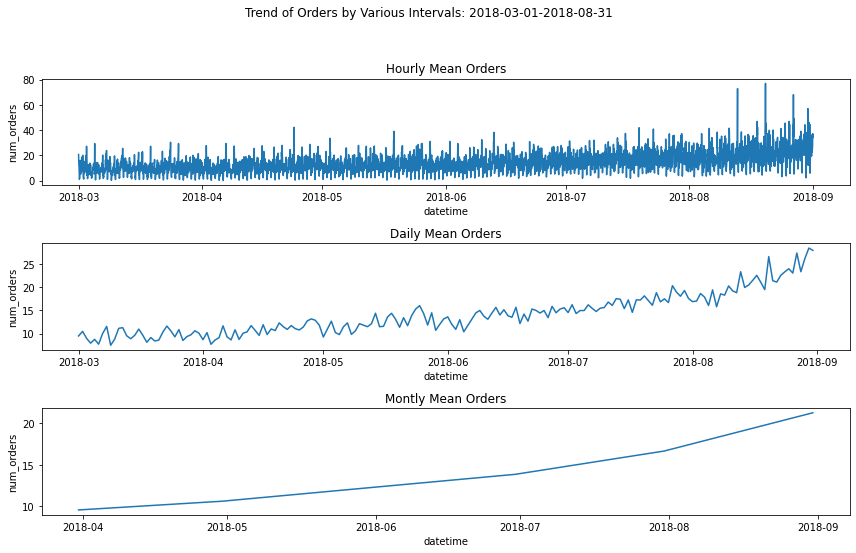

In [20]:
resample_df_list = [hourly_orders, daily_orders, monthly_orders]
titles = ['Hourly Mean Orders',
         'Daily Mean Orders',
         'Montly Mean Orders'
         ]
sup_title = 'Trend of Orders by Various Intervals: 2018-03-01-2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=4, c=1, titles=titles, sup_title=sup_title)

The overall trend reveals an upward trend in mean orders between March 3, 2018 and August 31, 2018.

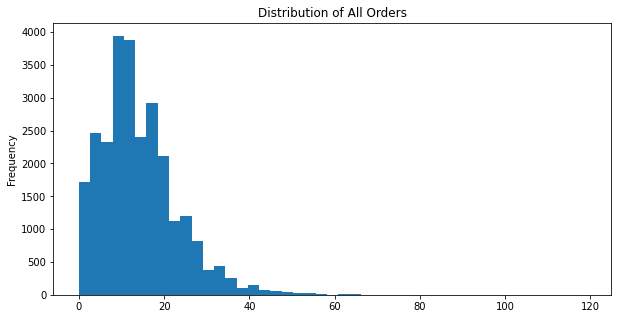

In [21]:
plt.subplots(figsize=(10, 5))
df['num_orders'].plot(kind='hist', bins=45, title='Distribution of All Orders')
plt.show()

The histogram has a right-skewed distribution, which peaks between 8 and 13 orders.

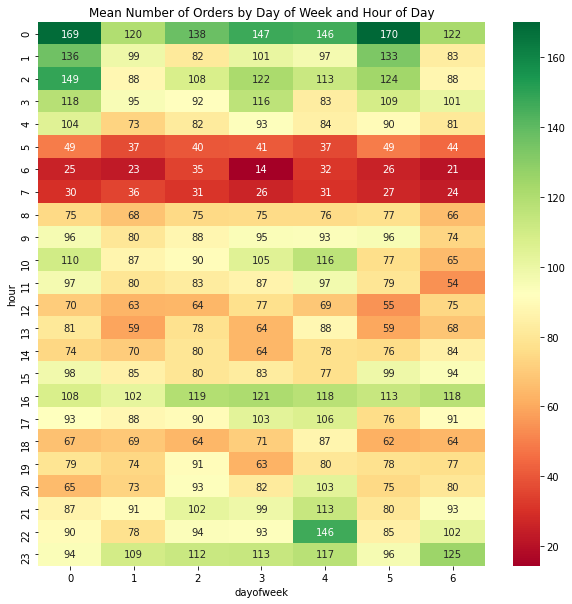

In [22]:
# creating a heat map of orders by hour of day and day of week

pivoted_df = df_hourly.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap="RdYlGn", fmt=".0f")
plt.title('Mean Number of Orders by Day of Week and Hour of Day')
plt.show()

 - Between 5:00AM and 7:00AM, the mean order of requests drops, and this pattern is observed throughout the week.
 - 12:00AM sees a higher than average number of orders compared to any other hour during any given week.
 - Between 8:00AM and 8:00PM, the number of rides is around the mean of 15.

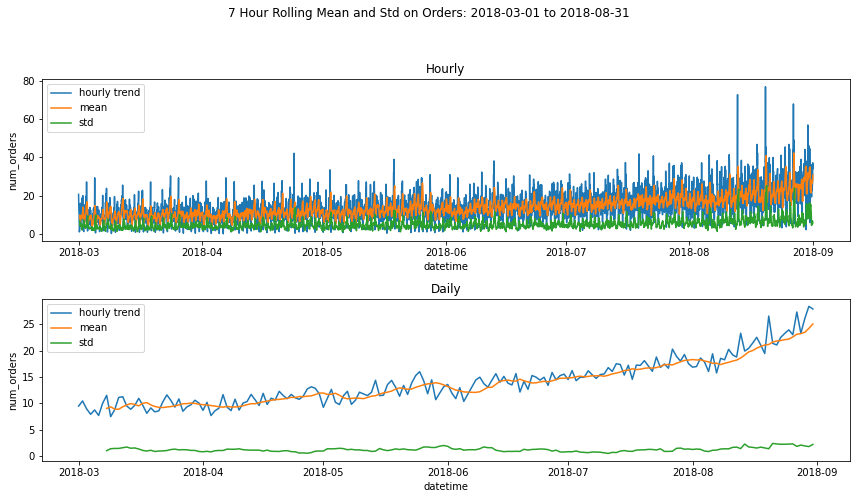

In [23]:
resample_df_list = [hourly_orders, daily_orders]
titles = [
         'Hourly',
         'Daily'
         ]
window = 7
sup_title = f'{window} Hour Rolling Mean and Std on Orders: 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=3, c=1, is_mean_window=True, window=window, 
            titles=titles, sup_title=sup_title)

The hourly data appears noisy, with the 7 hour mean and std noisy as well. In the daily orders, however, the std appears
constant, and the mean is relatively smoother.

In [24]:
# decomposing the time-series components

df_hourly = df_hourly.dropna()
display(df_hourly.shape)
display(df_hourly.head())

(4409, 15)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12,6,43,66,71,85,124,58.142857,66,41.558908
2018-03-01 08:00:00,34,3,1,3,8,15,12,6,43,66,71,85,42.571429,43,32.118827
2018-03-01 09:00:00,69,3,1,3,9,34,15,12,6,43,66,71,35.285714,34,26.113306
2018-03-01 10:00:00,64,3,1,3,10,69,34,15,12,6,43,66,35.000000,34,25.664502
2018-03-01 11:00:00,96,3,1,3,11,64,69,34,15,12,6,43,34.714286,34,25.269971


In [25]:
#decomposed = seasonal_decompose(df_hourly[['num_orders', 'rolling_mean', 'rolling_std']])

decomposed = seasonal_decompose(df_hourly['num_orders'])

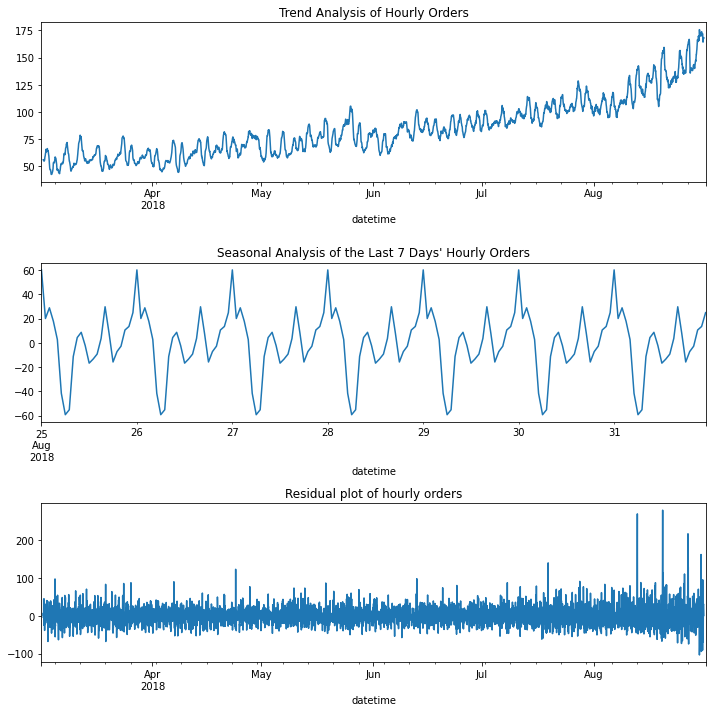

In [26]:
plt.figure(figsize=(10,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend Analysis of Hourly Orders')
plt.subplot(312)
decomposed.seasonal.tail(24*7).plot(ax=plt.gca())
plt.title("Seasonal Analysis of the Last 7 Days' Hourly Orders")
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title("Residual plot of hourly orders")

plt.tight_layout()

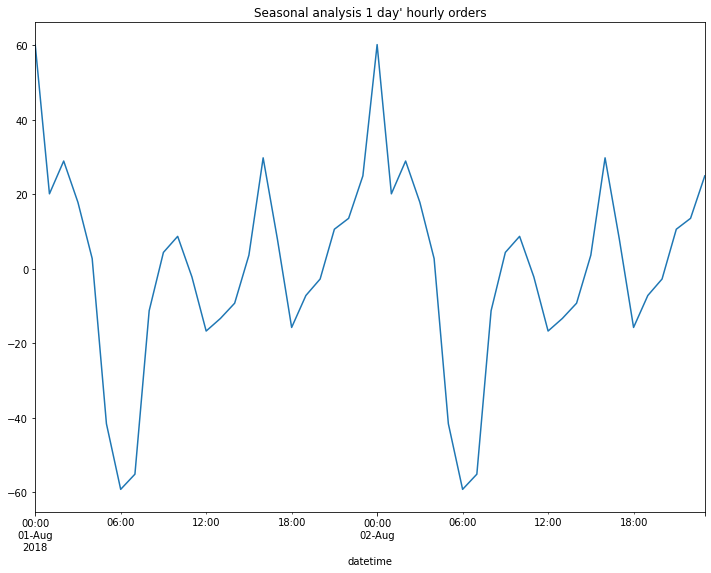

In [27]:
decomposed.seasonal['2018-08-01': '2018-08-02'].plot(figsize=(12, 9), title="Seasonal analysis 1 day' hourly orders")
plt.show()

 - The trend plot shows an upward trend.
 - The seasonal trend for last 7 days shows that there is a daily seasonal pattern in ridership.
 - The residuals shows that the spikes in August clearly indicate that the company was peaking with respect to ridership frequency.
 - The seasonal analysis for 1 day shows that ridership frequency increases at midnight, drops to its lowest at 6AM, and then rises moderately around 5PM.



## Training

In [28]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [29]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(1357)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_rmse = rmse(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [30]:
# splitting the dataframe

train_X, test_X, train_y, test_y = train_test_split(df_hourly.drop(['num_orders'], axis=1), 
                                              df_hourly['num_orders'], 
                                              test_size=0.2,
                                              random_state=1357, shuffle=False)

In [31]:
display(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(3527, 14)

(882, 14)

(3527,)

(882,)

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

In [33]:
lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=tscv)

In [34]:
rf = RandomForestRegressor(random_state=1357)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=tscv)

In [35]:
cat_features = []
cat = CatBoostRegressor(learning_rate=0.1, loss_function='RMSE',
                        random_seed=1357)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X.values, train_y.values, 
                                                        test_X.values, test_y.values,
                                                        hyperparameters={'iterations': range(100, 600, 100),
                                                                        'depth': range(5, 10)}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=tscv, model_str='catboost',
           cat_features=cat_features)

0:	learn: 27.9464840	total: 47.7ms	remaining: 4.72s
1:	learn: 27.0142131	total: 49.6ms	remaining: 2.43s
2:	learn: 25.9140648	total: 51.2ms	remaining: 1.65s
3:	learn: 25.2018913	total: 52.8ms	remaining: 1.27s
4:	learn: 24.4623199	total: 54.4ms	remaining: 1.03s
5:	learn: 23.6351805	total: 56ms	remaining: 877ms
6:	learn: 23.1759250	total: 57.6ms	remaining: 765ms
7:	learn: 22.6852455	total: 59.2ms	remaining: 681ms
8:	learn: 21.8953588	total: 60.9ms	remaining: 615ms
9:	learn: 21.2250070	total: 62.6ms	remaining: 564ms
10:	learn: 20.7736000	total: 64.5ms	remaining: 521ms
11:	learn: 20.4760330	total: 66.1ms	remaining: 485ms
12:	learn: 20.0236239	total: 67.7ms	remaining: 453ms
13:	learn: 19.7543600	total: 69.3ms	remaining: 426ms
14:	learn: 19.5509857	total: 70.9ms	remaining: 402ms
15:	learn: 19.1378233	total: 72.5ms	remaining: 381ms
16:	learn: 18.8338674	total: 74.1ms	remaining: 362ms
17:	learn: 18.6853460	total: 75.7ms	remaining: 345ms
18:	learn: 18.4130929	total: 77.3ms	remaining: 330ms
19:	l

In [36]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_cb_time]})

In [37]:
display(model_results_df)

,model,best_rmse,train_time
0,LinearRegression,48.616597,0.26
1,RandomForestRegressor,45.679298,363.48
2,CatBoostRegressor,45.739549,306.11


In [38]:
# finding the best CatBoostRegressor model params

display(best_cb_model.get_all_params())

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 1357,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function': 'Cosine',
 'task_typ

**Summary**
 - Three models were trained and tested in using grid search based on number of iterations and depth_size using 5 fold time-series cross validation.
 - The end result is that RandomForestRegressor had the lowest RMSE of all three models, although the training time it took is also the highest at 364 seconds.

## Testing

In [39]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return preds, np.round(time.time() - start_time, 2), rmse(test_y, preds)

In [40]:
preds, pred_time, best_rmse = test_prediction(best_cb_model, test_X.values, test_y)
display(f'The RMSE on the test set is {np.round(best_rmse, 2)}, and time to predict {np.round(pred_time, 4)} seconds')

'The RMSE on the test set is 45.74, and time to predict 0.01 seconds'

In [41]:
# checking the feature importance

display(pd.DataFrame(best_cb_model.feature_importances_,
index=train_X.columns, columns=['score']).sort_values('score', ascending=False))

,score
hour,47.483960
lag_1,10.676518
month,8.919226
lag_7,5.073254
rolling_mean,4.286585
lag_2,4.086336
dayofweek,3.926177
rolling_median,2.593803
lag_4,2.583591
lag_3,2.478821


 - The RMSE on the test set, using the model with the lowest RMSE, is 45 orders.
 - The top three important features are: hour, lag_1, month.

In [42]:
display(len(preds))

882

In [43]:
test_set = test_X.merge(df_hourly['num_orders'], left_index=True, right_index=True)['num_orders']
display(pd.DataFrame(test_set, columns=['num_orders']))

,num_orders
datetime,
2018-07-26 06:00:00,21
2018-07-26 07:00:00,39
2018-07-26 08:00:00,80
2018-07-26 09:00:00,138
2018-07-26 10:00:00,142
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Project Summary

 - The mean `'num_orders'` shows an upward trend in the last 5 months between March 1, 2018 and August 31, 2018.
 - The data was prepared by creating several date and time-series related features, such as, `'month'`, `'day'`, `'dayofweek'`, `'hour'`, `'lag_*'`, `'rolling_mean'`, `'rolling_median'`, and `'rolling_std'`.
 - The decomposition of time-series components shows a daily seasonality, which peaks at 12 AM, and drops to its lowest at 6AM, and during the day peaks at around 5PM.
 - RandomForestRegressor emerged as the best model with the lowest RMSE. However, it also took the longest to train the model.